In [1]:
import h5py
import pandas as pd

# %cd "chapter5"

In [116]:
# resfile = 'results_f2024-06-16.h5'
resfile = 'results_f2024-07-05.h5'
store = pd.HDFStore(resfile)
keysplit = []
for k in store.keys():
    keysplit.append(k.split('/'))
store.close()
print(keysplit)
dataset_types = ['sim', 'summary', 'tasks']
simulations = { f"{e[1]}/{e[2]}":{d:None for d in dataset_types} for e in keysplit  }
for simulation, dtype in simulations.items():
     for dst in dataset_types:
         simulations[simulation][dst] = pd.read_hdf(resfile,key=f"{simulation}/{dst}")
# for simulation, dtype in simulations.items():
#     print(simulations[simulation]['summary'])


[['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_3', 'sim'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_3', 'summary'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_3', 'tasks'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_2', 'sim'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_2', 'summary'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_2', 'tasks'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_1', 'sim'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_1', 'summary'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_1', 'tasks'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_0', 'sim'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_0', 'summary'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-39-09_0', 'tasks'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-37-48_9', 'sim'], ['', 'Fri240705143112', 'skaworkflows_2024-07-02_14-37-48_9', 'su

In [8]:
simulations.keys()

dict_keys(['Sat240629170202/skaworkflows_2024-06-25_20-53-01_8', 'Sat240629170202/skaworkflows_2024-06-25_20-48-36_9', 'Sat240629170202/skaworkflows_2024-06-25_20-48-36_1', 'Sat240629170202/skaworkflows_2024-06-25_20-43-57_9', 'Sat240629170202/skaworkflows_2024-06-25_20-43-57_4', 'Sat240629170202/skaworkflows_2024-06-25_20-43-57_3', 'Sat240629170202/skaworkflows_2024-06-25_20-43-57_2', 'Sat240629170202/skaworkflows_2024-06-25_20-43-57_1', 'Sat240629170202/skaworkflows_2024-06-25_20-39-03_8', 'Sat240629170202/skaworkflows_2024-06-25_20-39-03_7', 'Sat240629170202/skaworkflows_2024-06-25_20-39-03_4', 'Sat240629170202/skaworkflows_2024-06-25_20-39-03_3', 'Sat240629170202/skaworkflows_2024-06-25_20-37-49_9', 'Sat240629170202/skaworkflows_2024-06-25_20-37-49_8', 'Sat240629170202/skaworkflows_2024-06-25_20-37-49_7', 'Sat240629170202/skaworkflows_2024-06-25_20-37-49_4', 'Sat240629170202/skaworkflows_2024-06-25_20-37-11_6', 'Sat240629170202/skaworkflows_2024-06-25_20-36-15_7', 'Sat240629170202/

In [124]:
import matplotlib.pyplot as plt 
import json 
from pathlib import Path
df = None

df_total = pd.DataFrame()

for simulation, dtype in simulations.items():
    df = simulations[simulation]['summary']
    
    # print(df[(df['event']=='finished') | (df['event']=='started')]) # & df['actor']=='telescope'])
    # print(df[(df['event']=='stopped') & (df['actor']=='scheduler')]) # & df['actor']=='telescope']

    df_tel = (df[(df['actor']=='instrument')])
    
    obs_durations = []
    for obs in set(df_tel['observation']):
        df_obs = df_tel[df_tel['observation'] == obs]
        obs_durations.append(df_obs[df_obs['event']=='finished']['time'].iloc[0] 
            - df_obs[df_obs['event'] =='started']['time'].iloc[0])

    df_sim = simulations[simulation]['sim']
    # print(df_sim['available_resources'].iloc[0])
    cfg_path = Path(df_sim['config'].iloc[0])
    # cfg_path = cfg_path.parent / str(cfg_path.parent / 'processed' / cfg_path.name)
    # BASE_DIR = Path("examples/playground/config")
    # for cfg_path in os.listdir(BASE_DIR):
    #     if (BASE_DIR / cfg_path).is_dir():
    #         continue
    with open(cfg_path) as fp:
        cfg = json.load(fp)
    pipelines = cfg["instrument"]["telescope"]["pipelines"]
    nodes = len(cfg["cluster"]["system"]["resources"])
    observations = pipelines.keys()
    parameters = (
        pd.DataFrame.from_dict(pipelines, orient="index")
        .reset_index()
        .rename(columns={"index": "observation"})
    )
    parameters["nodes"] = nodes
    # parameters["dir"] = BASE_DIR
    
    # So long as the second last workflow is put on the scheduler 
    # before the sum of the total observations is complete, we should be fine. 
    # This means that the only thing that needs computing after the final observation
    # is the workflow associated with that observation, which means we aren't 
    # 'in the red' as far as the shedule is concerned. 
    
    # print(sum(obs_durations))
    print
    
    df_sched=df[(df['actor']=='scheduler')] # get the last "started" time of a workflow on the scheduler
    # print((sum(obs_durations) - sorted(df_sched[df_sched['event']=='stopped']['time'])[-2]) / (sum(obs_durations)))
    # print(sorted(df_tel['time'])[-2])
    # print
    # print(sum(obs_durations))
    success=True
    if (sum(obs_durations) - sorted(df_sched[df_sched['event']=='stopped']['time'])[-2]) < 0:
        success = False

    parameters['success'] = success
    parameters['success_ratio'] = (sum(obs_durations) - sorted(df_sched[df_sched['event']=='stopped']['time'])[-2])/sum(obs_durations)
    parameters['sim_cfg'] = cfg_path.name
    # print(parameters[['channels', 'coarse_channels', 'demand', 'success_ratio']])

    df_total=pd.concat([df_total, parameters],ignore_index=True)

dfgb = df_total.groupby(['sim_cfg'])


sims = []
ratios = []
for name, group in dfgb:
    # group['success_ratio'].iloc[0])
    sims.append(name[0])
    # ratios.append(float(group['success_ratio'].iloc[0]))
    # print(name, group[['success_ratio','demand', 'channels']])#.drop_duplicates())

df_sim[['planning', 'scheduling']]

,planning,scheduling
0,planning,scheduling
1,planning,scheduling
2,planning,scheduling
3,planning,scheduling
4,planning,scheduling
...,...,...
70690,planning,scheduling
70691,planning,scheduling
70692,planning,scheduling
70693,planning,scheduling


(array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 51.]),
 array([-1.89836111, -1.69950833, -1.50065556, -1.30180278, -1.10295   ,
        -0.90409722, -0.70524444, -0.50639167, -0.30753889, -0.10868611,
         0.09016667]),
 <BarContainer object of 10 artists>)

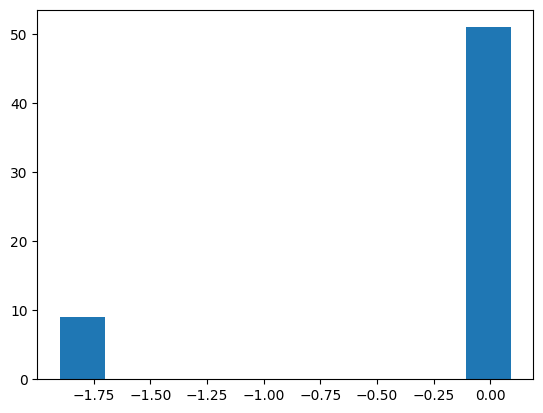

In [109]:
import seaborn as sns

demand, channels = {'success': [], 'failure':[]}, {'success': [], 'failure':[]}
for o in list(df_total['observation']):
    if bool(df_total[df_total['observation'] == o]['success'].iloc[0]):
        demand['success'].append(int(df_total[df_total['observation'] == o]['demand'].iloc[0]))
        channels['success'].append(int(df_total[df_total['observation'] == o]['coarse_channels'].iloc[0]))
    else:
        demand['failure'].append(int(df_total[df_total['observation'] == o]['demand'].iloc[0]))
        channels['failure'].append(int(df_total[df_total['observation'] == o]['coarse_channels'].iloc[0]))
# df_total['coarse_channels'] = df_total['coarse_channels'].astype('category')
# df_total['demand'] = df_total['demand'].astype('category')

fig, ax = plt.subplots()
# ax.hist(ratios)
# scatter = ax.hist(demand['success'],color='blue') #, channels['success'], c='blue')
# scatter = ax.hist(demand['failure'], color='orange') #, channels['failure'], c='red')
# fig, ax = plt.subplots()
# # ax.set_xticks(ticks=range(0,512, 128), labels=range(0, 512,128))
# g = sns.displot(data=df_total, x='demand', hue='success', multiple='dodge', binwidth=32, col='channels') #discrete=False) #, cbar=True,
# g = sns.displot(data=df_total, x='demand', hue='success', multiple='dodge') #, cbar=True,

# bins=16) #, ax=ax) # , hue='success', ax=ax, dodge=True)
# ax.set_xticks(range(-1, 12))
# label_range = range(0, 576, 64)
# ax.set_xticks(range(-1, len(label_range)-1))
# ax.set_xticklabels(label_range)
# # g.set_xticks(range(0, 512, 64))
# g.set_xticklabels(range(0, 512, 64))
                   # f, ax = plt.subplots()
# dataset = df_total.pivot(index='demand', columns='channels', values='success_ratio')
# sns.relplot(x='demand', y='coarse_channels', hue='success', data=df_total, col='nodes') # ,ax=ax)
# print(df_total[['channels', 'coarse_channels', 'demand', 'success_ratio']])
# sns

In [75]:
simulations.keys()

dict_keys(['Sun240616163628/skaworkflows_2024-06-16_15-36-15', 'Sun240616163628/skaworkflows_2024-06-16_15-35-55', 'Sun240616163628/skaworkflows_2024-06-16_14-41-49', 'Sun240616163627/skaworkflows_2024-06-16_15-06-51', 'Sun240616153637/skaworkflows_2024-06-16_15-36-15', 'Sun240616153637/skaworkflows_2024-06-16_15-35-55', 'Sun240616153637/skaworkflows_2024-06-16_14-41-49', 'Sun240616153636/skaworkflows_2024-06-16_15-06-51', 'Sun240616150714/skaworkflows_2024-06-16_14-41-49', 'Sun240616150713/skaworkflows_2024-06-16_15-06-51', 'Sun240616144209/skaworkflows_2024-06-16_14-41-49'])

([<matplotlib.axis.YTick at 0x7531785d5e40>,
 [Text(0, 0, 'hpso01_0: 2: Scheduler'),
  Text(0, 1, 'hpso01_0: 1: Telescope'),
  Text(0, 2, 'hpso01_1: 2: Scheduler'),
  Text(0, 3, 'hpso01_1: 1: Telescope'),
  Text(0, 4, 'hpso02a_2: 2: Scheduler'),
  Text(0, 5, 'hpso02a_2: 1: Telescope'),
  Text(0, 6, 'hpso02a_3: 2: Scheduler'),
  Text(0, 7, 'hpso02a_3: 1: Telescope'),
  Text(0, 8, 'hpso02a_4: 2: Scheduler'),
  Text(0, 9, 'hpso02a_4: 1: Telescope'),
  Text(0, 10, 'hpso02a_5: 2: Scheduler'),
  Text(0, 11, 'hpso02a_5: 1: Telescope'),
  Text(0, 12, 'hpso02b_6: 2: Scheduler'),
  Text(0, 13, 'hpso02b_6: 1: Telescope'),
  Text(0, 14, 'hpso02b_7: 2: Scheduler'),
  Text(0, 15, 'hpso02b_7: 1: Telescope'),
  Text(0, 16, 'hpso02b_8: 2: Scheduler'),
  Text(0, 17, 'hpso02b_8: 1: Telescope'),
  Text(0, 18, 'hpso02b_9: 2: Scheduler'),
  Text(0, 19, 'hpso02b_9: 1: Telescope')])

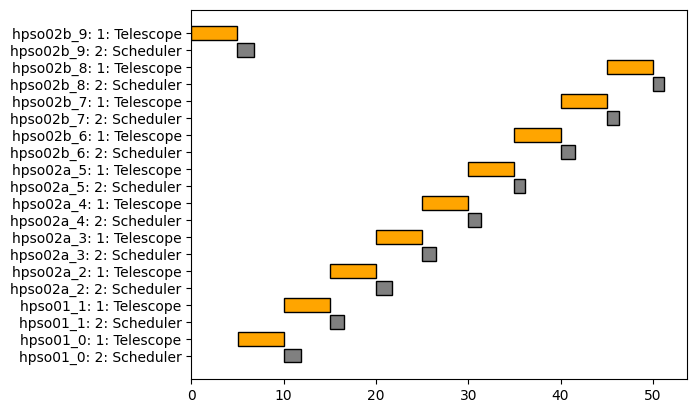

In [89]:
# Using resfile = 'results_f2024-06-16.h5'

import numpy as np
# df = simulations['Sun240616153636/skaworkflows_2024-06-16_15-06-51']['summary']
# df = simulations['Sun240616163628/skaworkflows_2024-06-16_14-41-49']['summary']
df = simulations['Sun240616163628/skaworkflows_2024-06-16_15-35-55']['summary'] # passes


# 'Sun240616163628/skaworkflows_2024-06-16_14-41-49'
actors = set(df['actor'])
# Observation telescope, started/finished
# observation buffer, start/end -> we don´t particularly care about buffer
# observation scheduler, added/removed
obs = set(df['observation'])
inst, sched = {}, {}
obs_d = {o: {} for o in obs}
for o in obs_d:
    obs_d[o]['telescope'] = df[(df['observation'] == o) & (df['actor'] == 'instrument')]
    obs_d[o]['scheduler'] = df[(df['observation'] == o) & (df['actor'] == 'scheduler')]

begin, end = [], []
obs_list = []
for o in sorted(obs):
    obs_list.append(f"{o}: 2: Scheduler")
    sdf = obs_d[o]['scheduler']
    begin.append(int(sdf[sdf['event'] == 'added']['time'].iloc[0])*5/3600)
    end.append(int(sdf[sdf['event'] == 'removed']['time'].iloc[0])*5/3600)
    obs_list.append(f"{o}: 1: Telescope")
    tdf = obs_d[o]['telescope']
    begin.append(int(tdf[tdf['event'] == 'started']['time'].iloc[0])*5/3600)
    end.append(int(tdf[tdf['event'] == 'finished']['time'].iloc[0])*5/3600)

import matplotlib.pyplot as plt 
plt.barh(range(len(begin)), np.array(end)-np.array(begin), color=['grey', 'orange'], left=np.array(begin), edgecolor='black')
plt.yticks(range(len(begin)), obs_list)

In [ ]:
def get_observation_duration(df):
    df_tel = (df[(df['actor']=='instrument')])

    for obs in set(df_tel['observation']):
        df_obs = df_tel[df_tel['observation'] == obs]
        print(df_obs[df_obs['event']=='finished']['time'].iloc[0] 
            - df_obs[df_obs['event'] =='started']['time'].iloc[0])


In [9]:
def get_config_parameters(config):
    pass

In [ ]:
def get_dataset_types(dataset_type):
    ds = {}
    In [47]: for simulation, dtype in simulations.items():
        ds[simulation] = simulations[simulation][dataset_type]

In [156]:
for simulation, dtype in simulations.items():
    df_sim = simulations[simulation]['sim']
    print(df_sim['available_resources'].iloc[0])
    df_tasks = simulations[simulation]['tasks']
    df_sim['config'].iloc[0]

256
/home/rwb/Dropbox/University/PhD/experiment_data/chapter4/playground/low/prototype/skaworkflows_2024-m-19_15-55-47.json
256
/home/rwb/Dropbox/University/PhD/experiment_data/chapter4/playground/low/prototype/skaworkflows_2024-m-19_15-55-28.json
256
/home/rwb/Dropbox/University/PhD/experiment_data/chapter4/playground/low/prototype/skaworkflows_2024-m-19_15-55-19.json
512
/home/rwb/Dropbox/University/PhD/experiment_data/chapter4/playground/low/prototype/skaworkflows_2024-05-19_20-56-10.json
512
/home/rwb/Dropbox/University/PhD/experiment_data/chapter4/playground/low/prototype/skaworkflows_2024-05-19_20-54-42.json
512
/home/rwb/Dropbox/University/PhD/experiment_data/chapter4/playground/low/prototype/skaworkflows_2024-05-19_20-54-32.json
512
/home/rwb/Dropbox/University/PhD/experiment_data/chapter4/playground/low/prototype/skaworkflows_2024-05-19_20-54-10.json
512
/home/rwb/Dropbox/University/PhD/experiment_data/chapter4/playground/low/prototype/skaworkflows_2024-05-19_20-54-01.json
128

TypeError: cannot unpack non-iterable int object